# Tworzenie modelu, predykcja na 7 i 30 dni

## Import bibliotek

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import joblib

## Wczytanie danych

In [5]:
df = pd.read_csv("../data/processed/energy_and_weather_data.csv", parse_dates=['time'])
df.head()

,time,total_load,temp,pressure,humidity,wind_speed,rain_1h,clouds_all
0,2015-01-01 00:00:00+00:00,24382.0,272.512700,1016.2,82.4,2.0,0.0,0.0
1,2015-01-01 01:00:00+00:00,22734.0,272.099137,1016.8,82.0,2.4,0.0,0.0
2,2015-01-01 02:00:00+00:00,21286.0,272.089469,1016.6,82.0,2.4,0.0,0.0
3,2015-01-01 03:00:00+00:00,20264.0,272.145900,1016.6,82.0,2.4,0.0,0.0
4,2015-01-01 04:00:00+00:00,19905.0,272.024000,1017.4,82.6,2.4,0.0,0.0


In [6]:
# Ustawienie indeksu czasowego
df = df.sort_values('time')
df.set_index('time', inplace=True)
df.head()

,total_load,temp,pressure,humidity,wind_speed,rain_1h,clouds_all
time,,,,,,,
2015-01-01 00:00:00+00:00,24382.0,272.512700,1016.2,82.4,2.0,0.0,0.0
2015-01-01 01:00:00+00:00,22734.0,272.099137,1016.8,82.0,2.4,0.0,0.0
2015-01-01 02:00:00+00:00,21286.0,272.089469,1016.6,82.0,2.4,0.0,0.0
2015-01-01 03:00:00+00:00,20264.0,272.145900,1016.6,82.0,2.4,0.0,0.0
2015-01-01 04:00:00+00:00,19905.0,272.024000,1017.4,82.6,2.4,0.0,0.0


## Inżynieria cech

In [8]:
# Dodanie cech czasowych
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# Okna z 24-godzinną średnią
df['load_rolling_3'] = df['total_load'].rolling(window=24).mean().shift(1)
df['temp_rolling_3'] = df['temp'].rolling(window=24).mean().shift(1)

# Usunięcie NaN powstałych przez rolling
df.dropna(inplace=True)

### Zapisanie zestawu danych dla modelu

In [131]:
df.head()

,total_load,temp,pressure,humidity,wind_speed,rain_1h,clouds_all,hour,dayofweek,month,load_rolling_3,temp_rolling_3
time,,,,,,,,,,,,
2015-01-02 00:00:00+00:00,24935.0,274.033700,1019.6,84.4,1.4,0.0,3.2,0,4,1,23966.958333,277.001207
2015-01-02 01:00:00+00:00,23214.0,273.592669,1019.0,84.8,1.6,0.0,0.0,1,4,1,23990.000000,277.064582
2015-01-02 02:00:00+00:00,22540.0,273.458331,1019.0,84.8,1.6,0.0,0.0,2,4,1,24010.000000,277.126812
2015-01-02 03:00:00+00:00,22096.0,273.464800,1019.2,85.0,1.6,0.0,2.0,3,4,1,24062.250000,277.183848
2015-01-02 04:00:00+00:00,22066.0,272.928938,1019.8,84.4,1.4,0.0,1.2,4,4,1,24138.583333,277.238802


In [118]:
df.to_csv('../data/processed/energy_and_weather_data_for_model.csv')

## Podział danych

In [10]:
# Podział na zbiór treningowy (75%: 2015-2017) i zbiór testowy (25%: 2018)
train = df[:'2018']
test = df['2018':]

features = ['temp', 'hour', 'dayofweek', 'month', 'load_rolling_3', 'temp_rolling_3']
target = 'total_load'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (35040, 6)
X_test shape: (8760, 6)
y_train shape: (35040,)
y_test shape: (8760,)


## Trening modelu

In [ ]:
# Parametry do przetestowania
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

model = RandomForestRegressor(random_state=42)

cv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Najlepsze parametry:", grid_search.best_params_)
best_model = grid_search.best_estimator_

## Ocena modelu

In [27]:
# Predykcja dla 2018 roku
y_pred = best_model.predict(X_test)

In [49]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 1180.77
RMSE: 1695.92
MAPE: 4.09%


### Histogram błędów

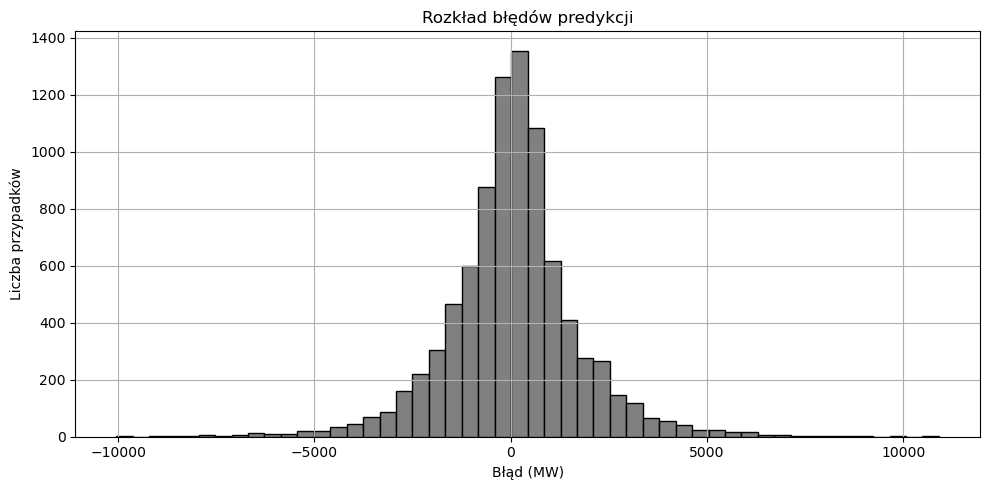

In [57]:
errors = y_test - y_pred

plt.figure(figsize=(10, 5))
plt.hist(errors, bins=50, color='gray', edgecolor='black')
plt.title('Rozkład błędów predykcji')
plt.xlabel('Błąd (MW)')
plt.ylabel('Liczba przypadków')
plt.grid(True)
plt.tight_layout()
plt.show()

### Wykres błędu w czasie

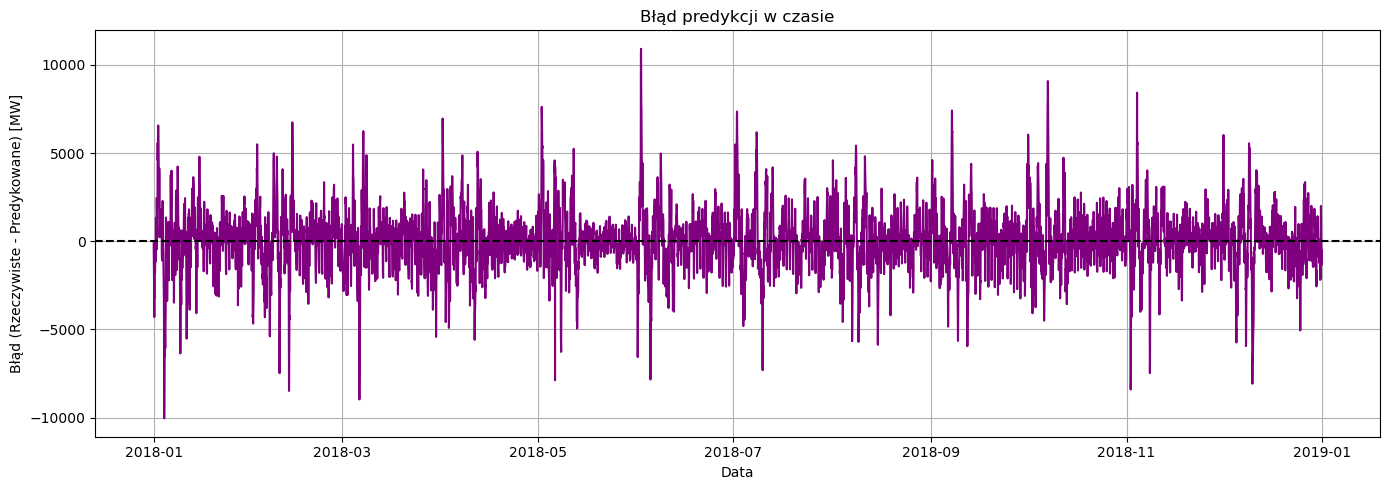

In [59]:
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, errors, label='Błąd', color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title('Błąd predykcji w czasie')
plt.xlabel('Data')
plt.ylabel('Błąd (Rzeczywiste - Predykowane) [MW]')
plt.grid(True)
plt.tight_layout()
plt.show()

### Wykres znaczenia cech

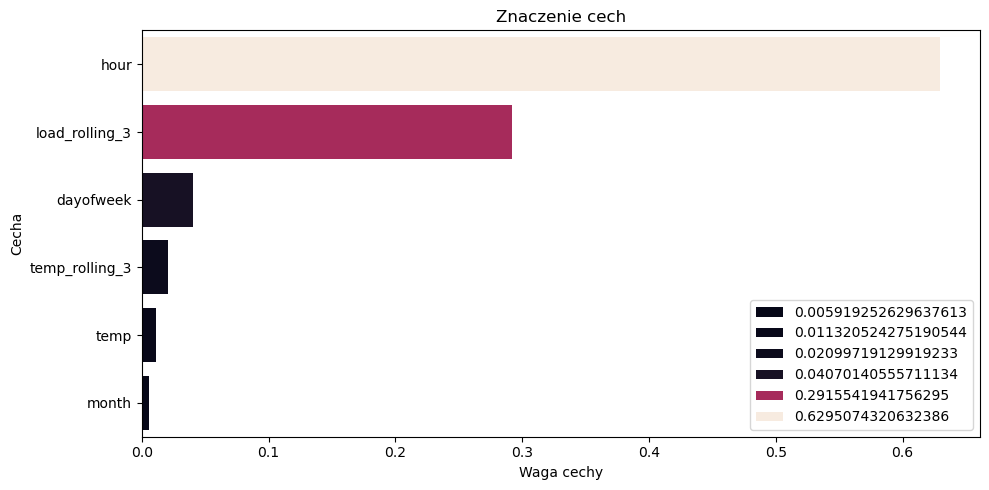

In [73]:
importances = best_model.feature_importances_
feature_names = X_train.columns

sorted_idx = importances.argsort()[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importances = importances[sorted_idx]

plt.figure(figsize=(10, 5))
sns.barplot(x=sorted_importances, y=sorted_features, hue=sorted_importances, palette='rocket')
plt.title('Znaczenie cech')
plt.xlabel('Waga cechy')
plt.ylabel('Cecha')
plt.tight_layout()
plt.show()

### Zapis modelu do pliku

In [80]:
joblib.dump(best_model, '../model/model.pkl')

['../model/model.pkl']